Robust MPC: Simulation with linearized rocket system

In [213]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
from LandMPC_deliverable_6_1.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *

# Require ipympl
%matplotlib widget 

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

sim_time = 10  # simulation length in seconds
x0 = np.zeros(12)
x0[11] = 10.0    # initial state

x_ref = np.array([0.]*9 + [1., 0., 3.]) # reference state
xs, us = rocket.trim(x_ref)


print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)
sys = rocket.linearize_sys(xs, us)
A, B = sys.A, sys.B

H = 2
mpc = MPCControl_z(A, B, xs, us, Ts, H)

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]


In [215]:
# t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='no_noise')
# vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
# plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=199, step=2), IntSlider(value=0…

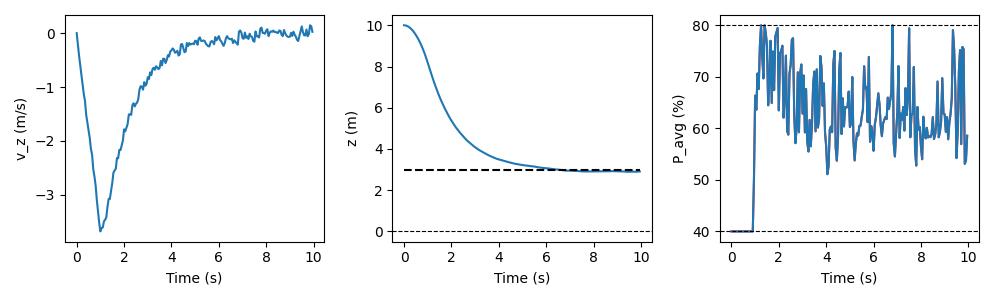

In [216]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='random')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=199, step=2), IntSlider(value=0…

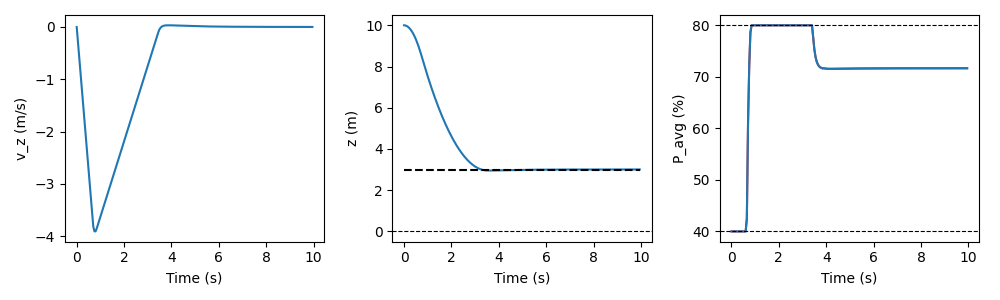

In [217]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')


In [218]:
import numpy as np

print("=== Tightened input set U~ (absolute) ===")
u_min_tight = float(mpc.us[0] + mpc.dv_min_tight) if hasattr(mpc, "dv_min_tight") else float(mpc.U_tight_vertices[0])
u_max_tight = float(mpc.us[0] + mpc.dv_max_tight) if hasattr(mpc, "dv_max_tight") else float(mpc.U_tight_vertices[1])
print("u_min_tight =", u_min_tight)
print("u_max_tight =", u_max_tight)

print("\n=== Error set E (box bounds in delta coords [vz,z]) ===")
print("E_lb =", mpc.E_lb)
print("E_ub =", mpc.E_ub)

print("\n=== Terminal set Xf ===")
Xf = getattr(mpc, "_Xf", None)
print("Xf available:", Xf is not None)
if Xf is not None:
    print("Xf inequalities: A shape", Xf.A.shape, "b shape", Xf.b.shape)


=== Tightened input set U~ (absolute) ===
u_min_tight = -15.350080590637795
u_max_tight = 135.3500805906378

=== Error set E (box bounds in delta coords [vz,z]) ===
E_lb = [-0.73427929 -0.58178403]
E_ub = [0.73427929 0.58178403]

=== Terminal set Xf ===
Xf available: True
Xf inequalities: A shape (1506, 2) b shape (1506,)


In [219]:
import numpy as np

def poly_vertices(P):
    # Try common vertex access patterns in mpt4py
    for name in ["V", "vertices", "Vertices", "extreme_points", "extremePoints", "getVertices"]:
        if hasattr(P, name):
            obj = getattr(P, name)
            V = obj() if callable(obj) else obj
            V = np.array(V, dtype=float)
            if V.ndim == 2 and V.shape[1] == 2:
                return V

    # fallback: print hints
    hints = [n for n in dir(P) if ("vert" in n.lower()) or (n.lower() == "v")]
    raise RuntimeError(f"Could not extract vertices. Possible methods: {hints}")

X = mpc._X      # constraint set used for terminal computation (blue)
Xf = mpc._Xf    # terminal invariant set (red)

V_X  = poly_vertices(X)
V_Xf = poly_vertices(Xf)

print("X vertices:", V_X.shape[0], "Xf vertices:", V_Xf.shape[0])


X vertices: 4 Xf vertices: 2


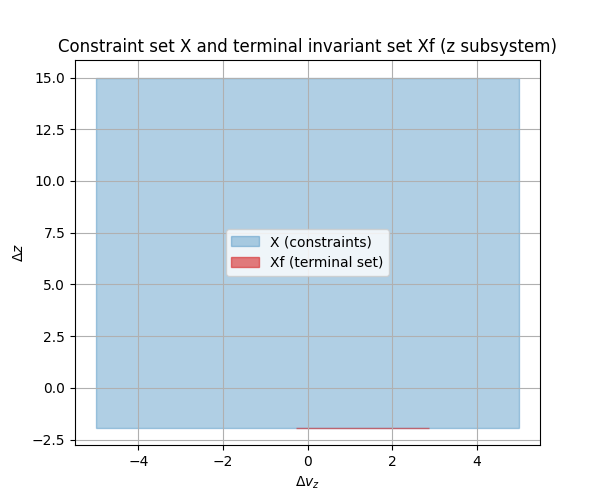

In [220]:
import matplotlib.pyplot as plt

def order_vertices(V):
    V = np.array(V, dtype=float)
    c = V.mean(axis=0)
    ang = np.arctan2(V[:,1] - c[1], V[:,0] - c[0])
    return V[np.argsort(ang)]

def filled_poly(ax, V, color, alpha, label):
    V = order_vertices(V)
    ax.fill(V[:,0], V[:,1], alpha=alpha, label=label, color=color)

plt.figure(figsize=(6,5))
ax = plt.gca()

filled_poly(ax, V_X,  color="tab:blue", alpha=0.35, label="X (constraints)")
filled_poly(ax, V_Xf, color="tab:red",  alpha=0.60, label="Xf (terminal set)")

ax.set_xlabel(r"$\Delta v_z$")
ax.set_ylabel(r"$\Delta z$")
ax.set_title("Constraint set X and terminal invariant set Xf (z subsystem)")
ax.grid(True)
ax.legend()
plt.show()


In [224]:

print("U~ vertices (absolute):", [u_min_tight, u_max_tight])


U~ vertices (absolute): [-15.350080590637795, 135.3500805906378]


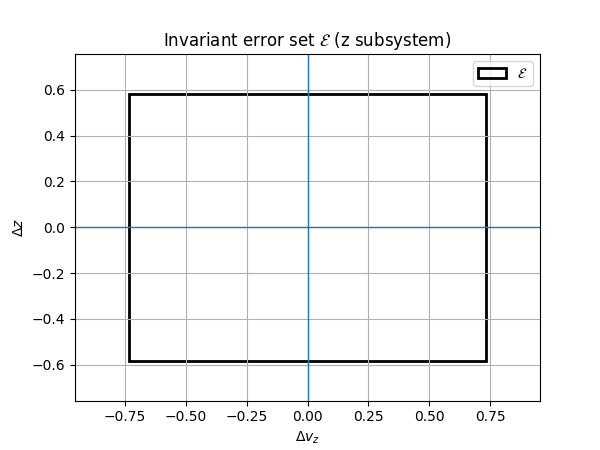

E bounds (Δ-coordinates):
E_lb = [-0.73427929 -0.58178403]
E_ub = [0.73427929 0.58178403]


In [223]:
# Cell: Plot invariant error set E (z subsystem) in Δ-coordinates
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_E(mpc, ax=None, title="Invariant error set $\\mathcal{E}$ (z subsystem)"):
    """
    Plots the invariant error set E for the z-subsystem in (Δv_z, Δz).
    Assumes your controller stores box bounds as:
        mpc.E_lb = [e_vz_min, e_z_min]
        mpc.E_ub = [e_vz_max, e_z_max]
    """
    E_lb = np.asarray(mpc.E_lb, dtype=float).reshape(-1)
    E_ub = np.asarray(mpc.E_ub, dtype=float).reshape(-1)

    if E_lb.size != 2 or E_ub.size != 2:
        raise ValueError(f"Expected 2D bounds for E (vz,z). Got sizes {E_lb.size}, {E_ub.size}")

    dvz_min, dz_min = E_lb[0], E_lb[1]
    dvz_max, dz_max = E_ub[0], E_ub[1]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6.0, 4.5))
    else:
        fig = ax.figure

    # Rectangle for E
    rect = Rectangle(
        (dvz_min, dz_min),
        dvz_max - dvz_min,
        dz_max - dz_min,
        fill=False,
        linewidth=2.0,
        label=r"$\mathcal{E}$"
    )
    ax.add_patch(rect)

    # cosmetics
    ax.axhline(0.0, linewidth=1.0)
    ax.axvline(0.0, linewidth=1.0)
    ax.set_xlabel(r"$\Delta v_z$")
    ax.set_ylabel(r"$\Delta z$")
    ax.set_title(title)
    ax.grid(True)
    ax.legend(loc="best")

    # nice limits with margin
    mx = 0.15 * max(1e-9, abs(dvz_max - dvz_min))
    my = 0.15 * max(1e-9, abs(dz_max - dz_min))
    ax.set_xlim(dvz_min - mx, dvz_max + mx)
    ax.set_ylim(dz_min - my, dz_max + my)

    return fig, ax

# Usage (after you've created your controller object `mpc`)
fig, ax = plot_E(mpc)
plt.show()

print("E bounds (Δ-coordinates):")
print("E_lb =", np.asarray(mpc.E_lb))
print("E_ub =", np.asarray(mpc.E_ub))
